In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
 98% 799M/812M [00:04<00:00, 238MB/s]
100% 812M/812M [00:04<00:00, 177MB/s]


In [ ]:
!ls
!mkdir dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!unzip -qq test1.zip
!mv train dogs-vs-cats
!mv test1 dogs-vs-cats
!mv sampleSubmission.csv dogs-vs-cats
!rm *.zip

dogs-vs-cats.zip  kaggle.json  sample_data


## Image properties

In [ ]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3

In [ ]:
filenames = os.listdir("./dogs-vs-cats/train/")

categories = []
for f_name in filenames:
  category = f_name.split(".")[0]
  if category == "dog":
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    "filename": filenames,
    "category": categories
})

## Creating Neural Net model

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
model2 = Sequential()

base_model = keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(Image_Width, Image_Height, Image_Channels),
    classes=2
)
for layer in base_model.layers:
    layer.trainable = False

model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(128, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(Dense(64, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_34 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_35 (Ba  (None, 61, 61, 64)       

In [ ]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_6  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               262400    
                                                                 
 batch_normalization_38 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                     

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=16

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./dogs-vs-cats/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./dogs-vs-cats/train/",
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./dogs-vs-cats/test1/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 20000 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
epochs=10
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10


<ipython-input-41-0303d50756ed>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1250/1250 [==============================] - 128s 103ms/step - loss: 0.6687 - accuracy: 0.6549 - val_loss: 0.5453 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 126s 101ms/step - loss: 0.5633 - accuracy: 0.7163 - val_loss: 0.5337 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 126s 101ms/step - loss: 0.5075 - accuracy: 0.7589 - val_loss: 0.6159 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 130s 104ms/step - loss: 0.4621 - accuracy: 0.7865 - val_loss: 0.7287 - val_accuracy: 0.6969 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 128s 102ms/step - loss: 0.4401 - accuracy: 0.8001 - val_loss: 0.4578 - val_accuracy: 0.8065 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 128s 102ms/step - loss: 0.4223 - accuracy: 0.8081 - val_loss: 0.5443 - val_accuracy: 0.7486 - lr: 0.0010
Epoch 7/10
1250/1250 [=======================

In [ ]:
epochs=2
history2 = model2.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/2


<ipython-input-53-8b9317d36e56>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(


1250/1250 [==============================] - 122s 98ms/step - loss: 0.1215 - accuracy: 0.9617 - val_loss: 0.0521 - val_accuracy: 0.9822 - lr: 5.0000e-04
Epoch 2/2
1250/1250 [==============================] - 123s 98ms/step - loss: 0.1199 - accuracy: 0.9607 - val_loss: 0.0516 - val_accuracy: 0.9808 - lr: 5.0000e-04


# Saving Model

In [ ]:
model2.save("model2_catsVSdogs_2epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("model1_catsVSdogs_10epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_filenames = os.listdir("./dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
test_df.sample(10)

,filename
9069,8699.jpg
4114,5570.jpg
6224,298.jpg
8188,10668.jpg
8741,5380.jpg
8268,7018.jpg
6053,4352.jpg
9632,2140.jpg
7068,4933.jpg
505,692.jpg


In [ ]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))  # Adjust target size based on the model architecture
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
def decode_binary_predictions(predictions, top=1):
    labels = ['cat', 'dog']  # Replace with your actual class labels
    decoded_predictions = [(labels[i], predictions[0][i]) for i in range(len(labels))]
    decoded_predictions.sort(key=lambda x: x[1], reverse=True)
    return decoded_predictions[:top]

1/1 [==============================] - 0s 21ms/step
[('dog', 0.9958038)]


1/1 [==============================] - 0s 21ms/step


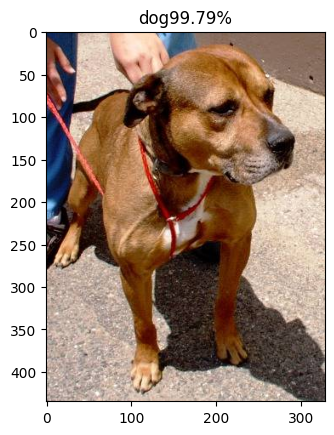

1/1 [==============================] - 0s 21ms/step


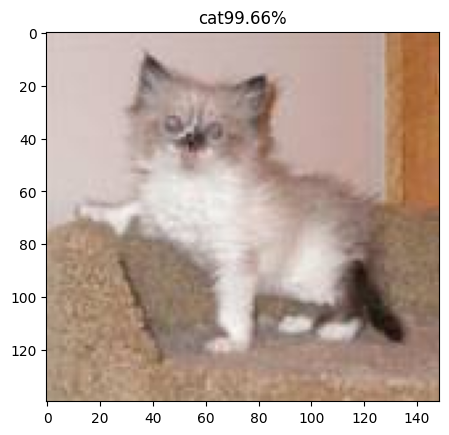

1/1 [==============================] - 0s 21ms/step


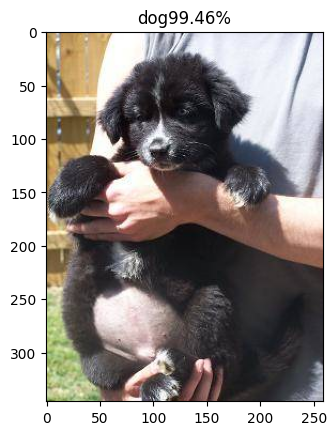

1/1 [==============================] - 0s 19ms/step


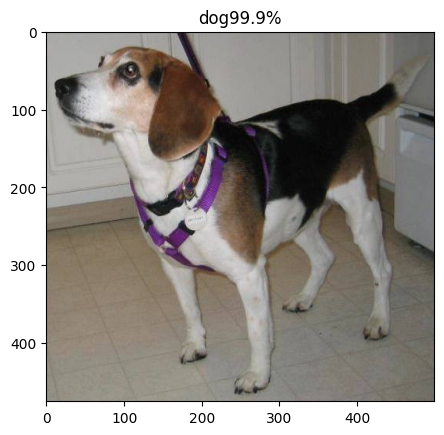

1/1 [==============================] - 0s 31ms/step


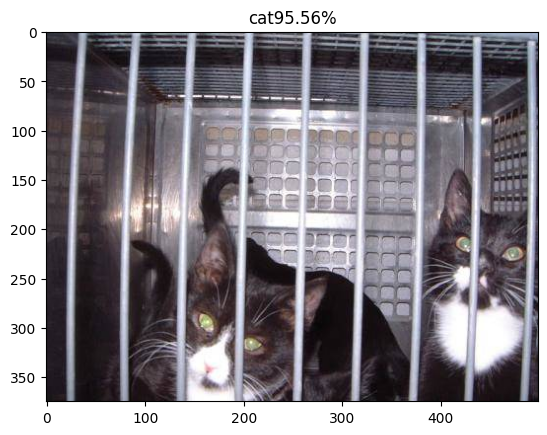

1/1 [==============================] - 0s 32ms/step


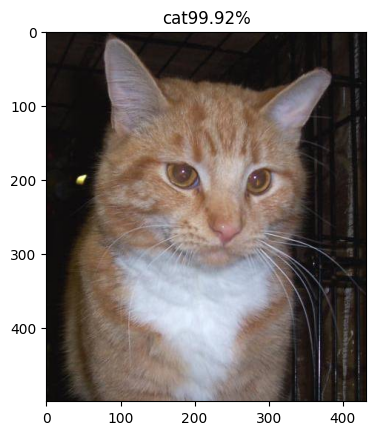

1/1 [==============================] - 0s 24ms/step


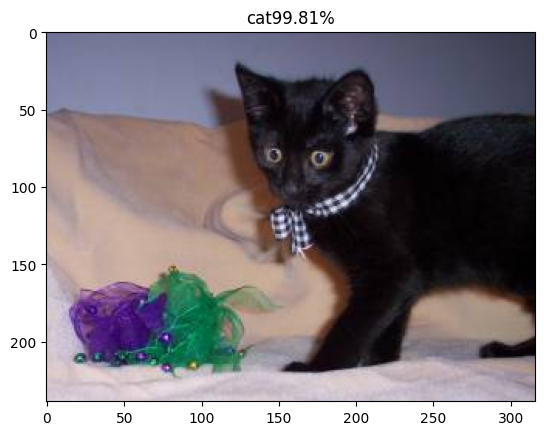

1/1 [==============================] - 0s 29ms/step


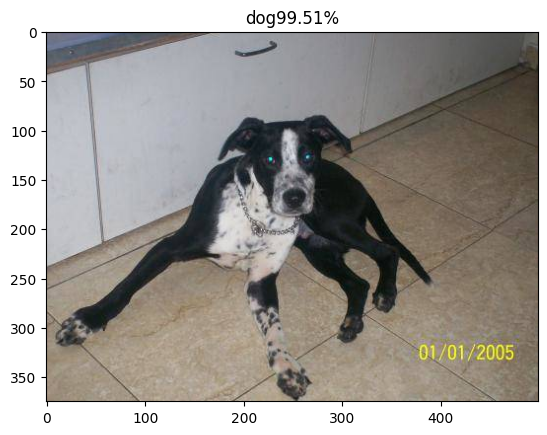

1/1 [==============================] - 0s 33ms/step


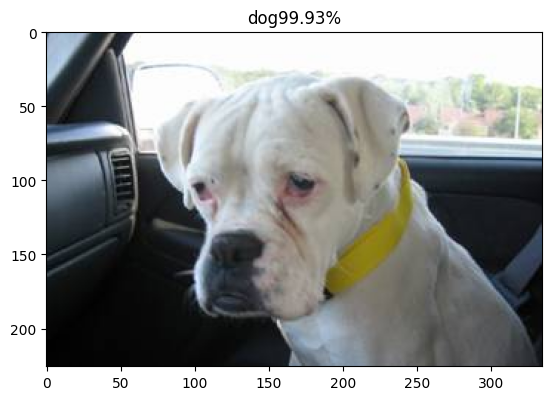

1/1 [==============================] - 0s 29ms/step


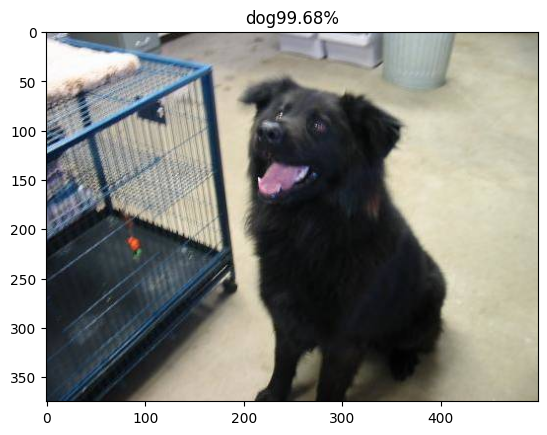

In [ ]:
from PIL import Image
for i in test_df.sample(10)["filename"].to_list():
  test_image = load_and_preprocess_image(f"dogs-vs-cats/test1/{i}")
  predictions = model2.predict(test_image)
  decoded_predictions = decode_binary_predictions(predictions, top=1)
  img = Image.open(f"dogs-vs-cats/test1/{i}")
  plt.imshow(img)
  plt.title(decoded_predictions[0][0] + str(round(decoded_predictions[0][1]*100, 2)) + "%")
  plt.show()
